In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import f1_score
import torch.nn.functional as F
from tqdm import trange, tqdm
# Đọc file CSV thành DataFrame
df = pd.read_csv("filtered_labels.csv")
df.head()


,STT,TEXT,COUNT,VIDEOS
0,1,1,1,D0530.mp4
1,2,2,1,D0531.mp4
2,3,3,1,D0532.mp4
3,4,4,1,D0533.mp4
4,5,5,1,D0534.mp4


In [2]:
df[["TEXT", "VIDEOS"]]

,TEXT,VIDEOS
0,1,D0530.mp4
1,2,D0531.mp4
2,3,D0532.mp4
3,4,D0533.mp4
4,5,D0534.mp4
5,6,D0535N.mp4; D0535T.mp4; D0535B.mp4
6,7,D0536.mp4
7,8,D0537.mp4
8,9,D0538.mp4
9,a,D0489.mp4


In [3]:
for i in df.index:
    files = [x.strip() for x in df.loc[i, "VIDEOS"].split(",")]
    print(f"Processing row {i}: {files}")

Processing row 0: ['D0530.mp4']
Processing row 1: ['D0531.mp4']
Processing row 2: ['D0532.mp4']
Processing row 3: ['D0533.mp4']
Processing row 4: ['D0534.mp4']
Processing row 5: ['D0535N.mp4; D0535T.mp4; D0535B.mp4']
Processing row 6: ['D0536.mp4']
Processing row 7: ['D0537.mp4']
Processing row 8: ['D0538.mp4']
Processing row 9: ['D0489.mp4']
Processing row 10: ['D0492.mp4']
Processing row 11: ['W00325.mp4']
Processing row 12: ['D0493.mp4']
Processing row 13: ['W00570N.mp4; W00570T.mp4; W00570B.mp4']
Processing row 14: ['W00739N.mp4; W00739T.mp4; W00739B.mp4']
Processing row 15: ['W00772B.mp4; W00772N.mp4; W00772T.mp4']
Processing row 16: ['D0494.mp4']
Processing row 17: ['D0496.mp4']
Processing row 18: ['D0498N.mp4; D0498B.mp4']
Processing row 19: ['D0500B.mp4; D0500N.mp4; D0500T.mp4']
Processing row 20: ['D0501.mp4']
Processing row 21: ['D0502.mp4']
Processing row 22: ['D0503.mp4']
Processing row 23: ['D0504.mp4']
Processing row 24: ['W02144.mp4']
Processing row 25: ['D0505.mp4']
Pro

In [4]:
#shape of vid:
cap = cv2.VideoCapture("Dataset/Video/D0001B.mp4")
if not cap.isOpened():
    print("Error: Could not open video.")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Video shape: {width}x{height}, FPS: {fps}")

Video shape: 1280x720, FPS: 29.97002997002997


In [5]:
def draw_keypoints(frame, keypoints):
    for point in keypoints:
        x, y = int(point[0] * frame.shape[1]), int(point[1] * frame.shape[0])
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    return frame

In [6]:
import cv2

def extract_frame(video_path: str, n: int, save_path: str | None = None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    # Nhảy tới khung thứ n (đếm từ 0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise ValueError(f"Khung {n} > tổng số khung của video")

    if save_path:
        cv2.imwrite(save_path, frame)   # lưu ra file ảnh
    return frame                       # hoặc trả về mảng numpy


In [ ]:
import mediapipe as mp
from config import Config
from detector import MediaPipeProcessor

pose = MediaPipeProcessor(Config())
results = []
def extract_video_keypoint(video_path):
    keypoints = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        results.append(result)
        keypoints.append(frame_keypoints)
    cap.release()
    return keypoints, results

2025-06-30 20:04:14.061420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 20:04:14.071867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751288654.084861   25833 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751288654.088372   25833 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 20:04:14.102393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
kpts, res = extract_video_keypoint("Dataset/Video/D0001B.mp4")
kpts

[array([[0.50105268, 0.28799707],
        [0.51235807, 0.25835687],
        [0.51846504, 0.25892198],
        [0.52515322, 0.25971293],
        [0.49177089, 0.25948477],
        [0.48476356, 0.26053023],
        [0.4782576 , 0.26152396],
        [0.53702515, 0.28010911],
        [0.46811682, 0.2816394 ],
        [0.51467562, 0.32350427],
        [0.48807755, 0.32205766],
        [0.59488791, 0.48611197],
        [0.41214603, 0.47078454],
        [0.60808134, 0.72349715],
        [0.37936622, 0.69869858],
        [0.61198318, 0.9463625 ],
        [0.37908462, 0.92722213],
        [0.61266702, 1.0142417 ],
        [0.3753522 , 1.00015116],
        [0.5974108 , 1.01502156],
        [0.39087865, 0.99273908],
        [0.59285903, 0.98984474],
        [0.39510158, 0.96399885],
        [0.55159992, 0.92707992],
        [0.44485611, 0.92623502],
        [0.54123628, 1.24833441],
        [0.431501  , 1.23686743],
        [0.53630501, 1.51688945],
        [0.43160191, 1.51081324],
        [0.536

In [9]:
for i, label, file_name in zip(df.index, df["TEXT"], df["VIDEOS"]):
    files = [x.strip() for x in file_name.split(",")]
    for file in files:
        print(f"Processing row {i}: {label} {file}")

Processing row 0: 1 D0530.mp4
Processing row 1: 2 D0531.mp4
Processing row 2: 3 D0532.mp4
Processing row 3: 4 D0533.mp4
Processing row 4: 5 D0534.mp4
Processing row 5: 6 D0535N.mp4; D0535T.mp4; D0535B.mp4
Processing row 6: 7 D0536.mp4
Processing row 7: 8 D0537.mp4
Processing row 8: 9 D0538.mp4
Processing row 9: a D0489.mp4
Processing row 10: b D0492.mp4
Processing row 11: bố W00325.mp4
Processing row 12: c D0493.mp4
Processing row 13: chị W00570N.mp4; W00570T.mp4; W00570B.mp4
Processing row 14: con chó W00739N.mp4; W00739T.mp4; W00739B.mp4
Processing row 15: con mèo W00772B.mp4; W00772N.mp4; W00772T.mp4
Processing row 16: d D0494.mp4
Processing row 17: e D0496.mp4
Processing row 18: g D0498N.mp4; D0498B.mp4
Processing row 19: h D0500B.mp4; D0500N.mp4; D0500T.mp4
Processing row 20: i D0501.mp4
Processing row 21: k D0502.mp4
Processing row 22: l D0503.mp4
Processing row 23: m D0504.mp4
Processing row 24: má W02144.mp4
Processing row 25: n D0505.mp4
Processing row 26: nước Việt nam W02555

In [10]:
# import numpy as np

# for i, file_names in zip(df.index, df["VIDEO"]):
#     print(f"Processing row {i}: {file_names}")
#     files = [x.strip() for x in file_names.split(",")]
#     for file in files:
#         video_path = f"data/Video_60frames/{file}"
#         keypoints, _ = extract_video_keypoint(video_path)
#         file_name = file.split(".")[0]
#         np.save(f"data/Keypoints/{file_name}.npy", keypoints)
#         print(f"Saved keypoints for {file} to data/keypoints/{file_name}.npy", len(keypoints))
        

In [11]:
class LoadData(Dataset):
    """
    Dataset that selects frames at indices [offset, offset+5, offset+10, ...]
    without truncation. Returns raw sequence per sample.
    Keypoints loaded from keypoints_dir (.npy shape: (T, F)).
    Labels loaded from label_dir   (.npy shape: (T,)).
    """
    def __init__(self, keypoints_dir, label_dir, offset):
        self.keypoints_dir = keypoints_dir
        self.label_dir = label_dir
        self.offset = offset
        # find common base filenames
        kp_files = {os.path.splitext(f)[0] for f in os.listdir(keypoints_dir) if f.endswith('.npy')}
        lbl_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir)   if f.endswith('.npy')}
        self.common = sorted(kp_files & lbl_files)

    def __len__(self):
        return len(self.common)

    def __getitem__(self, idx):
        base = self.common[idx]
        # load full sequences
        kp_seq = np.load(os.path.join(self.keypoints_dir, f"{base}.npy"))  # (T, F)
        lbl_seq= np.load(os.path.join(self.label_dir,   f"{base}.npy"))   # (T,)
        # select every 5th frame starting at offset
        seq_kp = kp_seq[self.offset::5]
        seq_lbl= lbl_seq[self.offset::5]
        # convert to tensors directly (length may vary per sample)
        return torch.from_numpy(seq_kp).float(), torch.from_numpy(seq_lbl).long()

In [12]:
def add_noise(kp_seq: torch.Tensor, std: float = 0.02) -> torch.Tensor:
    """Add Gaussian noise to keypoint sequence."""
    return kp_seq + torch.randn_like(kp_seq) * std


def random_frame_dropout(kp_seq: torch.Tensor, drop_prob: float = 0.1) -> torch.Tensor:
    """Randomly drop frames from a sequence."""
    mask = torch.rand(kp_seq.shape[0], device=kp_seq.device) > drop_prob
    return kp_seq[mask]

In [13]:
def create_dataloaders(keypoints_dir, label_dir, batch_size=32, augment: bool = False):
    """
    Creates train and validation DataLoaders padded to the max sequence length across the entire dataset.
    Offsets 0-3 for train, offset 4 for val. No truncation; pad at beginning.
    """
    # instantiate datasets for each offset
    train_datasets = [LoadData(keypoints_dir, label_dir, offs) for offs in range(4)]
    val_dataset    = LoadData(keypoints_dir, label_dir, 4)
    train_ds = ConcatDataset(train_datasets)

    # compute global max length across both train and val
    all_ds = ConcatDataset(train_datasets + [val_dataset])
    max_len = 0
    for kp, _ in all_ds:
        if kp.shape[0] > max_len:
            max_len = kp.shape[0]

    # custom collate function
    def collate_pad_to_max(batch):
        kp_seqs, lbl_seqs = zip(*batch)
        F = kp_seqs[0].shape[1]
        kp_batch, lbl_batch = [], []
        for kp_seq, lbl_seq in zip(kp_seqs, lbl_seqs):
            if augment:
                orig_len = kp_seq.shape[0]
                aug_seq = add_noise(kp_seq)
                aug_seq = random_frame_dropout(aug_seq)
                # sync lengths: limit to original length
                L_aug = aug_seq.shape[0]
                L_sync = min(L_aug, orig_len)
                kp_seq = aug_seq[-L_sync:]
                lbl_seq = lbl_seq[-L_sync:]
            L = kp_seq.shape[0]
            if L > max_len:
                kp_seq = kp_seq[-max_len:]
                lbl_seq = lbl_seq[-max_len:]
            if L < max_len:
                pad_count = max_len - L
                pad_shape = (pad_count, *kp_seq.shape[1:])
                pad_kp = torch.zeros(pad_shape, dtype=kp_seq.dtype, device=kp_seq.device)
                pad_lbl = torch.zeros((pad_count,), dtype=lbl_seq.dtype, device=lbl_seq.device)
                kp_seq = torch.cat([pad_kp, kp_seq], dim=0)
                lbl_seq = torch.cat([pad_lbl, lbl_seq], dim=0)
            kp_batch.append(kp_seq)
            lbl_batch.append(lbl_seq)
        kp_batch = torch.stack(kp_batch, dim=0)  # (B, max_len, F)
        lbl_batch= torch.stack(lbl_batch, dim=0) # (B, max_len)
        return kp_batch, lbl_batch

    # DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    train_labels = []
    for seq, lbl in train_loader:
        # lbl có shape (batch_size, T), nhãn cuối cùng của mỗi sequence là lbl[i, -1]
        for i in range(lbl.shape[0]):
            train_labels.append(int(lbl[i, -1].item()))

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_pad_to_max
    )
    return train_loader, val_loader, max_len

In [14]:
kp_dir = 'data/Keypoints'
lbl_dir= 'data/Labels'
train_loader, val_loader, global_max_len = create_dataloaders(
    kp_dir, lbl_dir, batch_size=32
)
print(f"Global max sequence length: {global_max_len}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")

# Inspect first batch
for kp_batch, lbl_batch in train_loader:
    print(f"Batch keypoints shape: {kp_batch.shape}")  # (B, global_max_len, F)
    print(f"Batch labels shape:    {lbl_batch.shape}")  # (B, global_max_len)
    break

Global max sequence length: 30
Train batches: 10
Val batches:   3
Batch keypoints shape: torch.Size([32, 30, 150])
Batch labels shape:    torch.Size([32, 30])


In [15]:
class ModelCheckpoint:
    """
    Save the model when monitored metric improves.
    """
    def __init__(self, filepath: str, monitor: str = 'val_loss', verbose: bool = False):
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.best = float('inf') if 'loss' in monitor else -float('inf')

    def __call__(self, metrics: dict, model: torch.nn.Module):
        """
        metrics: dictionary containing monitored values, e.g. {'val_loss': x, 'val_acc': y}
        """
        current = metrics.get(self.monitor)
        if current is None:
            return
        improved = (current < self.best) if 'loss' in self.monitor else (current > self.best)
        if improved:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                return True
        return False


In [16]:
import torch
import torch.nn as nn

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, num_classes, kernel_size=3, dropout=0.5):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                              dilation=dilation, padding=(kernel_size - 1) * dilation,
                              dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        # x: (batch, seq_len, features) → transpose to (batch, features, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)  # shape: (batch, channels, seq_len)
        out = out[:, :, -1]    # lấy output cuối cùng
        return self.fc(out)


In [17]:
def train_tcn(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    window_size: int = 15,
    num_epochs: int = 10,
    checkpoint: ModelCheckpoint = None
) -> dict:
    """
    Train with sliding windows, compute macro-F1, show progress bars, and log to 'training_tcn.txt'.
    """
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}

    log_file = open('training_tcn.txt', 'w')
    header = f"{'Epoch':>7} | {'Train Loss':>10} | {'Train F1':>9} | {'Val Loss':>9} | {'Val F1':>7}"
    print(header)
    log_file.write(header + "\n")
    check = False
    for epoch in range(1, num_epochs+1):
        # --- training ---
        model.train()
        total_loss, total_windows = 0.0, 0
        train_preds, train_targets = [], []
        for seqs, lbls in train_loader:
            seqs, lbls = seqs.to(device), lbls.to(device)
            B, T, F = seqs.shape
            if T < window_size: continue
            windows = seqs.unfold(1, window_size, 1).reshape(-1, window_size, F)
            targets = lbls[:, window_size-1:].reshape(-1)

            optimizer.zero_grad()
            logits = model(windows)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * windows.size(0)
            total_windows += windows.size(0)

            preds = logits.argmax(dim=1)
            train_preds.append(preds.cpu())
            train_targets.append(targets.cpu())

        train_loss = total_loss / total_windows
        y_pred_train = torch.cat(train_preds).numpy()
        y_true_train = torch.cat(train_targets).numpy()
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro', zero_division=0)

        # --- validation ---
        model.eval()
        val_loss_sum, val_windows = 0.0, 0
        val_preds, val_targets = [], []
        for seqs, lbls in val_loader:
            seqs, lbls = seqs.to(device), lbls.to(device)
            B, T, F = seqs.shape
            if T < window_size: continue
            windows = seqs.unfold(1, window_size, 1).reshape(-1, window_size, F)
            targets = lbls[:, window_size-1:].reshape(-1)

            with torch.no_grad():
                logits = model(windows)
            val_loss_sum += criterion(logits, targets).item() * windows.size(0)
            val_windows += windows.size(0)

            preds = logits.argmax(dim=1)
            val_preds.append(preds.cpu())
            val_targets.append(targets.cpu())

        val_loss = val_loss_sum / val_windows
        y_pred_val = torch.cat(val_preds).numpy()
        y_true_val = torch.cat(val_targets).numpy()
        val_f1 = f1_score(y_true_val, y_pred_val, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        if checkpoint:
            check = checkpoint({'val_loss': val_loss, 'val_f1': val_f1}, model)
        line = (
            f"{epoch:>3}/{num_epochs:<3} | "
            f"{train_loss:>10.4f} | "
            f"{train_f1:>9.4f} | "
            f"{val_loss:>9.4f} | "
            f"{val_f1:>7.4f}"  f"{' | Check' if check else ''}"
        )
        print(line)
        log_file.write(line + "\n")
        log_file.flush()


    log_file.close()
    return history

In [18]:
feature_size = 150
hidden_size  = 256
num_classes  = 52
dropout      = 0.5
window_size  = 15
num_epochs   = 300
batch_size   = 16
lr           = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- here’s the only change: use a list, not an int  --
num_levels   = 5
num_channels = [hidden_size] * num_levels 

# data loaders
kp_dir = 'data/Keypoints'
lbl_dir = 'data/Labels'
train_loader, val_loader, _ = create_dataloaders(kp_dir, lbl_dir, batch_size=batch_size, augment=True)
checkpoint = ModelCheckpoint('best_model_tcn.pth', monitor='val_f1', verbose=True)
# build model
model = TCNClassifier(
    input_size   = feature_size,
    num_channels = num_channels,
    num_classes  = num_classes,
    dropout      = dropout
)
model.to(device)

# loss, optimizer, training
class_weights = torch.ones(num_classes, device=device)
class_weights[0] = class_weights[1] = 0.065
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_hist = train_tcn(
    model, train_loader, val_loader, criterion, optimizer, device, window_size, num_epochs, checkpoint
)


  Epoch | Train Loss |  Train F1 |  Val Loss |  Val F1
  1/300 |     3.6883 |    0.0187 |    3.3279 |  0.0287 | Check
  2/300 |     3.2012 |    0.0390 |    3.0306 |  0.0315 | Check
  3/300 |     3.0172 |    0.0444 |    2.8994 |  0.0513 | Check
  4/300 |     2.8523 |    0.0510 |    2.7034 |  0.0678 | Check
  5/300 |     2.7463 |    0.0589 |    2.7300 |  0.0533
  6/300 |     2.6676 |    0.0602 |    2.5416 |  0.0684 | Check
  7/300 |     2.5734 |    0.0660 |    2.4608 |  0.0870 | Check
  8/300 |     2.4754 |    0.0836 |    2.3344 |  0.1014 | Check
  9/300 |     2.4523 |    0.0937 |    2.3386 |  0.0860
 10/300 |     2.3943 |    0.0898 |    2.1748 |  0.1243 | Check
 11/300 |     2.2978 |    0.1100 |    2.1756 |  0.1142
 12/300 |     2.2894 |    0.1260 |    2.2283 |  0.0776
 13/300 |     2.2874 |    0.1017 |    2.0819 |  0.1324 | Check
 14/300 |     2.2470 |    0.1129 |    2.0890 |  0.1462 | Check
 15/300 |     2.1830 |    0.1172 |    2.0856 |  0.1455
 16/300 |     2.1012 |    0.1342 |    2.

In [19]:
def inference(
    model: nn.Module,
    seq: torch.Tensor,
    device: torch.device,
    window_size: int = 15
) -> torch.Tensor:
    """
    Perform inference using sliding windows on a single sequence.
    Returns predictions for each window.
    """
    model.eval()
    seq = seq.to(device).unsqueeze(0)
    T, F = seq.size(1), seq.size(2)
    if T < window_size:
        return torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        windows = seq.unfold(1, window_size, 1).contiguous().view(-1, window_size, F)
        logits = model(windows)
        preds = torch.argmax(logits, dim=1)
    return preds.cpu()

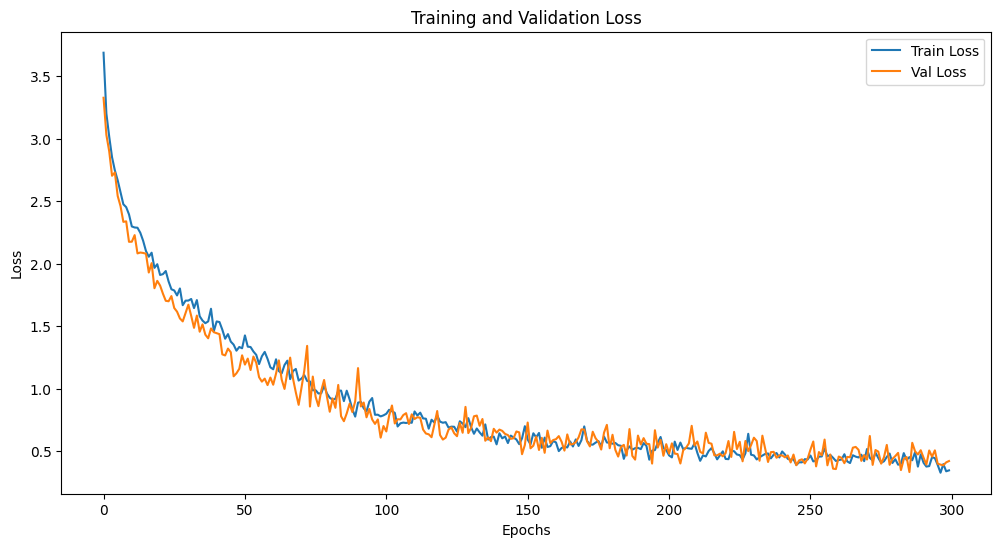

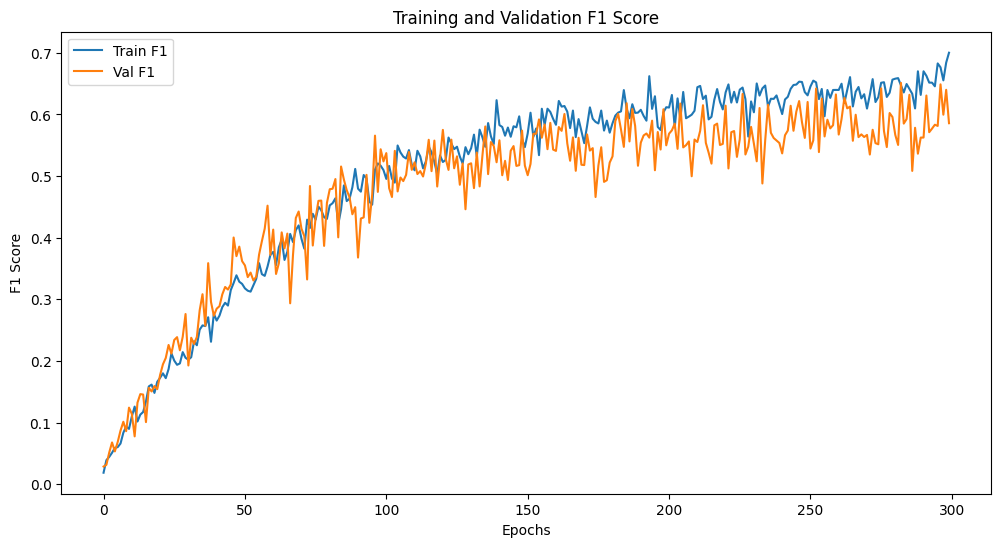

In [20]:
import matplotlib.pyplot as plt
#show history train and val loss
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_loss'], label='Train Loss')
plt.plot(loss_hist['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
#show history train and val acc
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_f1'], label='Train F1')
plt.plot(loss_hist['val_f1'], label='Val F1')
plt.xlabel('Epochs')    
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.show()


In [21]:
def print_aligned(preds, truths):
    preds = list(preds)
    truths = list(truths)
    preds_line = "Preds:".ljust(7) + "".join(f"{p:^{5}}" for p in preds)
    truth_line= "Truth:".ljust(7) + "".join(f"{t:^{5}}" for t in truths)
    print(preds_line)
    print(truth_line)
    print("-" * 20)

In [22]:
model.load_state_dict(torch.load('best_model_tcn.pth'))
model.to(device)
for seq, lbls in val_loader.dataset:
        preds = inference(model, seq, device, window_size)
        truths = lbls[window_size-1:].tolist()
        print_aligned(preds, truths)

# --- Evaluation on full validation set ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Remove seaborn dependency; use matplotlib for confusion matrix
import matplotlib.pyplot as plt

all_preds, all_truths = [], []
for seq, lbls in val_loader.dataset:
    preds = inference(model, seq, device, window_size)
    truths = lbls[window_size-1:].tolist()
    all_preds.extend(preds.tolist())
    all_truths.extend(truths)

acc = accuracy_score(all_truths, all_preds)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(all_truths, all_preds, zero_division=0))

Preds:  37   37   37    0  
Truth:  37   37    0    0  
--------------------
Preds:  39   10   10   10  
Truth:  10   10   10   10  
--------------------
Preds:  41    0    0  
Truth:  41    0    0  
--------------------
Preds:  41   41   41   41   41   41   41    0    0    0    0  
Truth:   0    0   41   41   41   41    0    0    0    0    0  
--------------------
Preds:  41   41   41   41   41   41   41    0    0    0    0  
Truth:   0    0   41   41   41   41    0    0    0    0    0  
--------------------
Preds:  38   38   38   40   40   40    0  
Truth:   0   38   38   38   38    0    0  
--------------------
Preds:  38   38   38   38   38   38    0    0  
Truth:   0   38   38   38   38    0    0    0  
--------------------
Preds:  38   38   38   38   38   38    0    0  
Truth:   0   38   38   38   38    0    0    0  
--------------------
Preds:  11   13   39   10  
Truth:  11    0    0    0  
--------------------
Preds:  13   10  
Truth:  13    0  
--------------------
Preds:   0

In [23]:
#take vide from data/datatest and inference mediapipe keypoints and inference model
def process_video(video_path, model, device, window_size=15):
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps // 6)
    frame_count = 0
    if frame_interval == 0:
        frame_interval = 1
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    keypoints = np.zeros((window_size, 150), dtype=np.float32)  # Assuming 126 keypoints per frame
    results = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        frame_keypoints = frame_keypoints.reshape(-1)

        keypoints = np.vstack((keypoints, frame_keypoints))
        keypoints = np.array(keypoints[1:])
        seq_tensor = torch.from_numpy(keypoints).float().to(device)
        preds = inference(model, seq_tensor, device, window_size)
        preds = preds.cpu().numpy()
        results.append(preds[0])
        frame_count += 1
    cap.release()
    # Convert to tensor and perform inference
    return results

In [24]:
#take video from data/datatest
path = "data/datatest"
video_files = [f for f in os.listdir(path) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(path, video_file)
    print(f"Processing video: {video_path}")
    results = process_video(video_path, model, device, window_size)
    print(f"Results for {video_file}: {results}")

Processing video: data/datatest/bộ đội.mp4
Results for bộ đội.mp4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing video: data/datatest/thương yêu.mp4
Results for thương yêu.mp4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing video: data/datatest/thường xuyên.mp4
Results for thường xuyên.mp4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing video: data/datatest/sữa bò.mp4
Results for sữa bò.mp4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing video: data/datatest/tưởng tượng.mp4
Results for tưởng tượng.mp4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing video: data/datatest/sữa bột.mp4
Results for sữa bột.mp4: [0, 0, 0, 0, 0, 0, 0, 0